In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv("data_train.csv",index_col=0)
test_df = pd.read_csv("data_test.csv", index_col=0)

In [3]:
test_df.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


In [4]:
train_df.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


In [5]:
train_df.shape

(831653, 4)

In [6]:
columns = np.arange(3,256)

In [7]:
small_dtype = {}

In [8]:
for item in columns:
    small_dtype[item] = np.float32

In [9]:
features_df = pd.read_csv("features.csv",sep="\t", index_col=0, dtype=small_dtype, nrows=1000000)
features_df.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910028,46.980888,4.969214,-1.386798,3.791754,-14.011789,-16.08618,-65.076096,...,-977.373840,-613.770813,-25.996269,-37.630447,-301.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
1,2014722,1539550800,36.690029,152.400894,448.069214,563.833191,463.841766,568.998230,-16.08618,-53.216099,...,-891.373840,-544.770813,-20.996269,48.369553,80.252274,-13.832889,-0.694429,-1.175933,-0.456140,0.0
2,2015199,1545598800,-67.019974,157.050888,-63.180786,178.103195,-68.598244,156.998215,3.51382,25.183903,...,-977.373840,-613.770813,-12.996268,-37.630447,10829.251953,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,2021765,1534107600,7.010029,150.200882,-6.930786,216.213196,76.621758,351.848206,-16.08618,-65.076096,...,-973.373840,-613.770813,-23.996269,-37.630447,-205.747726,-24.832888,-0.694429,-11.175933,-0.456140,1.0
4,2027465,1533502800,-90.439972,134.220886,-104.380783,153.643204,-109.798248,132.538208,-16.08618,-65.076096,...,1643.626099,2007.229248,206.003738,-21.630449,6667.252441,92.167114,-0.694429,49.824066,47.543861,0.0


In [10]:
features_df["252"].value_counts()

0.0      746300
1.0      253662
5.0           3
2.0           3
13.0          3
10.0          2
68.0          2
82.0          1
94.0          1
101.0         1
137.0         1
9.0           1
146.0         1
39.0          1
25.0          1
41.0          1
60.0          1
12.0          1
195.0         1
209.0         1
342.0         1
15.0          1
23.0          1
36.0          1
282.0         1
283.0         1
18.0          1
4.0           1
19.0          1
314.0         1
79.0          1
7.0           1
Name: 252, dtype: int64

In [11]:
features_df = features_df.loc[features_df["252"].isin([0,1]),:]

In [12]:
features_df["id"] = features_df["id"].astype("int8")
features_df["buy_time"] = features_df["buy_time"].astype("int8")

In [13]:
features_df.memory_usage(deep=True)

Index       7999696
id           999962
buy_time     999962
0           3999848
1           3999848
             ...   
248         3999848
249         3999848
250         3999848
251         3999848
252         3999848
Length: 256, dtype: int64

In [14]:
X = features_df.drop("252", axis=1)
y = features_df["252"]

In [15]:
print("ID уникален? {}".format(X.index.is_unique))
print("Сколько дубликатов? {}".format(X.duplicated().sum()))
print("Каков процент пропусков? {} ".format((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален? True
Сколько дубликатов? 221
Каков процент пропусков? 0.0 


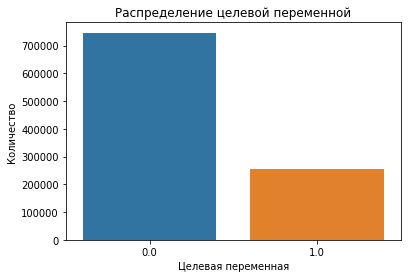

In [16]:
import seaborn as sns
ax = sns.countplot(y)
ax.set_xlabel("Целевая переменная")
ax.set_ylabel("Количество")
ax.set_title("Распределение целевой переменной");

In [17]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

train_idx, test_idx = train_test_split(X.index, test_size=0.35, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.745789
1.0    0.254211
Name: 252, dtype: float64

Test
0.0    0.747331
1.0    0.252669
Name: 252, dtype: float64


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

In [19]:
log_reg_step = ("logistic_regression", LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))

In [20]:
base_estimator = Pipeline([log_reg_step])

In [21]:
def run_cv(estimator, X, y, scoring='f1', model_name=""):
    cv_res = cross_validate(estimator, X, y, scoring=scoring, n_jobs=-1)
    print("{} {}={:.2f}(+/-{:.4f})".format(model_name, scoring, cv_res['test_score'].mean(), cv_res['test_score'].std() *2))

In [22]:
run_cv(base_estimator, X_train, y_train, model_name="Baseline")

Baseline f1=0.42(+/-0.0034)


In [23]:
base_estimator.fit(X_train, y_train)

Pipeline(steps=[('logistic_regression',
                 LogisticRegression(n_jobs=-1, random_state=42))])

In [24]:
base_preds = base_estimator.predict_proba(X_test)[:,1]

In [25]:
from sklearn.metrics import classification_report

In [26]:
print(classification_report(y_test, base_preds > 0.5))

              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75    261556
         1.0       0.36      0.50      0.42     88431

    accuracy                           0.65    349987
   macro avg       0.58      0.60      0.59    349987
weighted avg       0.69      0.65      0.67    349987



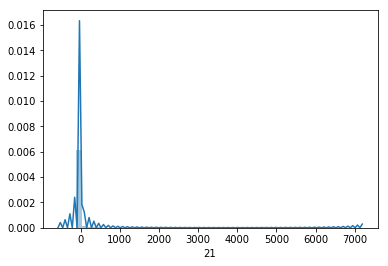

In [54]:
sns.distplot(features_df["21"])